Change .cpu() to .cuda() to compute much quicker.

In [45]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [46]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import transforms

torch.manual_seed(2)

In [47]:
import torch
from torch import nn


class AttackerStep:
    '''
    Generic class for attacker steps, under perturbation constraints
    specified by an "origin input" and a perturbation magnitude.
    Must implement project, step, and random_perturb
    '''

    def __init__(self, orig_input, eps, step_size, use_grad=True):
        '''
        Initialize the attacker step with a given perturbation magnitude.
        Args:
            eps (float): the perturbation magnitude
            orig_input (ch.tensor): the original input
        '''
        self.orig_input = orig_input
        self.eps = eps
        self.step_size = step_size
        self.use_grad = use_grad

    def project(self, x):
        '''
        Given an input x, project it back into the feasible set
        Args:
            ch.tensor x : the input to project back into the feasible set.
        Returns:
            A `ch.tensor` that is the input projected back into
            the feasible set, that is,
        .. math:: \min_{x' \in S} \|x' - x\|_2
        '''
        raise NotImplementedError

    def step(self, x, g):
        '''
        Given a gradient, make the appropriate step according to the
        perturbation constraint (e.g. dual norm maximization for :math:`\ell_p`
        norms).
        Parameters:
            g (ch.tensor): the raw gradient
        Returns:
            The new input, a ch.tensor for the next step.
        '''
        raise NotImplementedError

    def random_perturb(self, x):
        '''
        Given a starting input, take a random step within the feasible set
        '''
        raise NotImplementedError

    def to_image(self, x):
        '''
        Given an input (which may be in an alternative parameterization),
        convert it to a valid image (this is implemented as the identity
        function by default as most of the time we use the pixel
        parameterization, but for alternative parameterizations this functino
        must be overriden).
        '''
        return x


# L2 threat model
class L2Step(AttackerStep):
    """
    Attack step for :math:`\ell_\infty` threat model. Given :math:`x_0`
    and :math:`\epsilon`, the constraint set is given by:
    .. math:: S = \{x | \|x - x_0\|_2 \leq \epsilon\}
    """

    def project(self, x):
        """
        """
        if self.orig_input is None: self.orig_input = x.detach()
        self.orig_input = self.orig_input.cpu()
        diff = x - self.orig_input
        diff = diff.renorm(p=2, dim=0, maxnorm=self.eps)
        return diff + self.orig_input

    def step(self, x, g):
        """
        """
        l = len(x.shape) - 1
        g_norm = torch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1] * l))
        scaled_g = g / (g_norm + 1e-10)
        return x + scaled_g * self.step_size


def targeted_pgd_l2(model, X, y, num_iter, eps=30, step_size=0.5):
    steper = L2Step(eps=eps, orig_input=None, step_size=step_size)
    for t in range(num_iter):
        X = X.clone().detach().requires_grad_(True).cpu()
        loss = nn.CrossEntropyLoss(reduction='none')(model((X)), y)
        loss = torch.mean(loss)
        grad, = torch.autograd.grad(-1 * loss, [X])
        X = steper.step(X, grad)
        X = steper.project(X)
    return X.detach()




In [48]:
import torch
from torch import nn


class AttackerStep:
    '''
    Generic class for attacker steps, under perturbation constraints
    specified by an "origin input" and a perturbation magnitude.
    Must implement project, step, and random_perturb
    '''

    def __init__(self, orig_input, eps, step_size, use_grad=True):
        '''
        Initialize the attacker step with a given perturbation magnitude.
        Args:
            eps (float): the perturbation magnitude
            orig_input (ch.tensor): the original input
        '''
        self.orig_input = orig_input
        self.eps = eps
        self.step_size = step_size
        self.use_grad = use_grad

    def project(self, x):
        '''
        Given an input x, project it back into the feasible set
        Args:
            ch.tensor x : the input to project back into the feasible set.
        Returns:
            A `ch.tensor` that is the input projected back into
            the feasible set, that is,
        .. math:: \min_{x' \in S} \|x' - x\|_2
        '''
        raise NotImplementedError

    def step(self, x, g):
        '''
        Given a gradient, make the appropriate step according to the
        perturbation constraint (e.g. dual norm maximization for :math:`\ell_p`
        norms).
        Parameters:
            g (ch.tensor): the raw gradient
        Returns:
            The new input, a ch.tensor for the next step.
        '''
        raise NotImplementedError

    def random_perturb(self, x):
        '''
        Given a starting input, take a random step within the feasible set
        '''
        raise NotImplementedError

    def to_image(self, x):
        '''
        Given an input (which may be in an alternative parameterization),
        convert it to a valid image (this is implemented as the identity
        function by default as most of the time we use the pixel
        parameterization, but for alternative parameterizations this functino
        must be overriden).
        '''
        return x


# Linf threat model
class LinfStep(AttackerStep):
    """
    Attack step for Linf threat model. Given x0 and epsilon, the constraint set is given by:
    S = {x | ||x - x0||_inf <= epsilon}
    """

    def project(self, x):
        """
        """
        if self.orig_input is None:
            self.orig_input = x.detach()
        self.orig_input = self.orig_input.cpu()
        diff = torch.clamp(x - self.orig_input, -self.eps, self.eps)
        return diff + self.orig_input

    def step(self, x, g):
        """
        """
        sign = torch.sign(g)
        return x + sign * self.step_size

def targeted_pgd_linf(model, X, y, num_iter, eps=0.3, step_size=0.01):
    steper = LinfStep(eps=eps, orig_input=None, step_size=step_size)
    for t in range(num_iter):
        X = X.clone().detach().requires_grad_(True).cpu()
        loss = nn.CrossEntropyLoss()(model(X), y)
        grad, = torch.autograd.grad(loss, [X])
        X = steper.step(X, grad)
        X = steper.project(X)
    return X.detach()

def untargeted_pgd_linf(model, X, num_iter, eps=0.3, step_size=0.01, sign=-1):
    steper = LinfStep(eps=eps, orig_input=None, step_size=step_size)
    for t in range(num_iter):
        X = X.clone().detach().requires_grad_(True).cpu()
        loss = model(X)
        loss = torch.mean(loss)
        grad, = torch.autograd.grad(sign * loss, [X])
        X = steper.step(X, grad)
        X = steper.project(X)
    return X.detach()


Synthetic Toy Dataset

In [49]:
dist = 10

In [50]:
# train set
mode1_1 = (dist * torch.tensor([-5., 0]) + torch.randn(size=(1000, 2,)))
mode1_1[:,1] = mode1_1[:,0] * 2

mode2_1 = (dist * torch.tensor([-3., 0]) + torch.randn(size=(1000, 2,)))
mode2_1[:,1] = mode2_1[:,0] * 2

mode1_2 = (dist * torch.tensor([-1., 0]) + torch.randn(size=(1000, 2,)))
mode1_2[:,1] = mode1_2[:,0] * 2

mode2_2 = (dist * torch.tensor([1., 0]) + torch.randn(size=(1000, 2,)))
mode2_2[:,1] = mode2_2[:,0] * 2

mode1_3 = (dist * torch.tensor([3., 0]) + torch.randn(size=(1000, 2,)))
mode1_3[:,1] = mode1_3[:,0] * 2

mode2_3 = (dist * torch.tensor([5., 0]) + torch.randn(size=(1000, 2,)))
mode2_3[:,1] = mode2_3[:,0] * 2

y1 = torch.zeros((3000,))
y2 = torch.ones((3000,))

X = torch.cat([mode1_1, mode1_2, mode1_3, mode2_1, mode2_2, mode2_3], dim=0)
Y = torch.cat([y1, y2], dim=0).long()

# X = (X - train_mean) / train_std

dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)

In [51]:
# test set
mode1_1 = (dist * torch.tensor([-5., 0]) + torch.randn(size=(100, 2,)))
mode1_1[:,1] = mode1_1[:,0] * 2

mode2_1 = (dist * torch.tensor([-3., 0]) + torch.randn(size=(100, 2,)))
mode2_1[:,1] = mode2_1[:,0] * 2

mode1_2 = (dist * torch.tensor([-1., 0]) + torch.randn(size=(100, 2,)))
mode1_2[:,1] = mode1_2[:,0] * 2

mode2_2 = (dist * torch.tensor([1., 0]) + torch.randn(size=(100, 2,)))
mode2_2[:,1] = mode2_2[:,0] * 2

mode1_3 = (dist * torch.tensor([3., 0]) + torch.randn(size=(100, 2,)))
mode1_3[:,1] = mode1_3[:,0] * 2

mode2_3 = (dist * torch.tensor([5., 0]) + torch.randn(size=(100, 2,)))
mode2_3[:,1] = mode2_3[:,0] * 2

y1 = torch.zeros((300,))
y2 = torch.ones((300,))

X = torch.cat([mode1_1, mode1_2, mode1_3, mode2_1, mode2_2, mode2_3], dim=0)
Y = torch.cat([y1, y2], dim=0).long()

# X = (X - train_mean) / train_std

testset = torch.utils.data.TensorDataset(X, Y)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=1)

In [52]:
mode1 = torch.cat((mode1_1, mode1_2, mode1_3), dim=0)
mode2 = torch.cat((mode2_1, mode2_2, mode2_3), dim=0)

visualize it

(-57.97998332977295, 57.83756160736084, -115.9599666595459, 115.67512321472168)

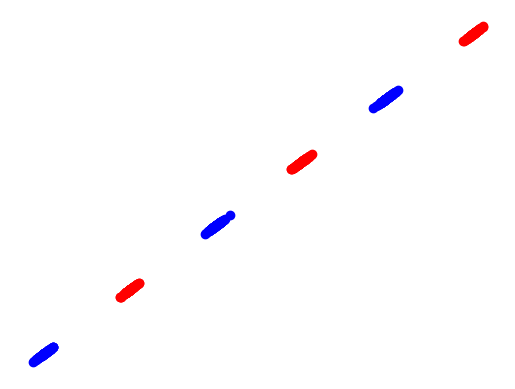

In [53]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(mode1[:,0], mode1[:,1], color = "blue")
ax.scatter(mode2[:,0], mode2[:,1], color = "red")
plt.axis('off')

Simple two layers MLP

In [54]:
torch.manual_seed(2)

class MLP(nn.Module):
    def __init__(self):
      super(MLP, self).__init__()
      self.layers = nn.Sequential(
          nn.Linear(in_features=2, out_features=32),
          nn.ReLU(),
          nn.Linear(in_features=32, out_features=2)
      )
    def forward(self, x):
      return self.layers(x)

    def predict(self, x):
      out = self.layers(x)
      return torch.argmax(out, dim=1)

net = MLP()
criterion = nn.CrossEntropyLoss()

# specify loss function
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2091240863.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2091240863.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')


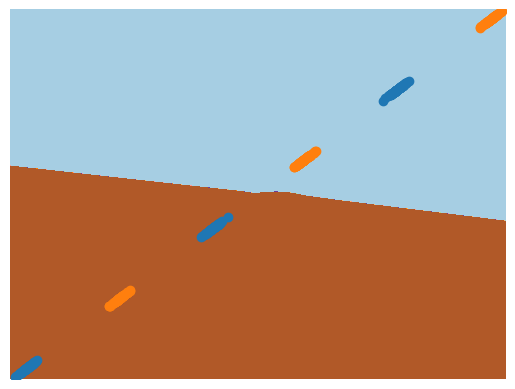

Epoch 0 / 100: avg_train_loss = 24.858102798461914, test_Acc = 0.6000000238418579


C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2091240863.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2091240863.py:74: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')


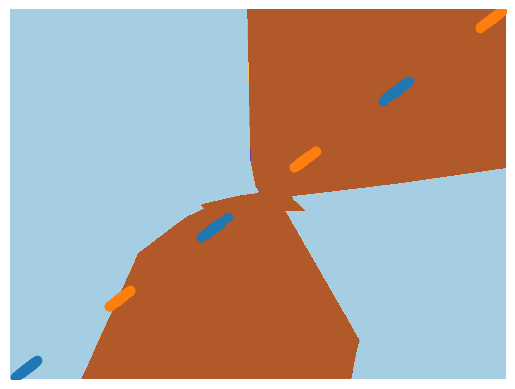

Epoch 1 / 100: avg_train_loss = 8.141840353608131, test_Acc = 0.5
Epoch 2 / 100: avg_train_loss = 7.985535591840744, test_Acc = 0.6666666865348816
Epoch 3 / 100: avg_train_loss = 7.973198756575584, test_Acc = 0.6666666865348816
Epoch 4 / 100: avg_train_loss = 8.310091346502304, test_Acc = 0.6399999856948853
Epoch 5 / 100: avg_train_loss = 8.359487235546112, test_Acc = 0.6666666865348816
Epoch 6 / 100: avg_train_loss = 7.884167641401291, test_Acc = 0.6666666865348816
Epoch 7 / 100: avg_train_loss = 7.775347009301186, test_Acc = 0.6666666865348816
Epoch 8 / 100: avg_train_loss = 8.15830510854721, test_Acc = 0.6666666865348816
Epoch 9 / 100: avg_train_loss = 7.82146917283535, test_Acc = 0.6666666865348816


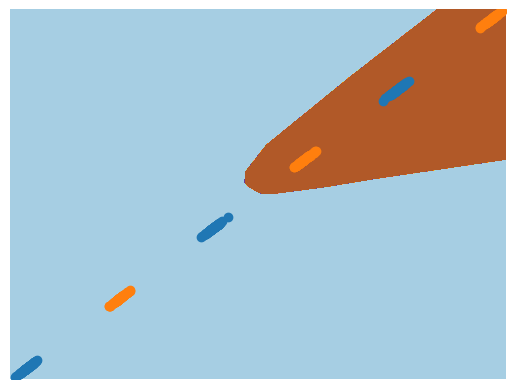

Epoch 10 / 100: avg_train_loss = 7.926867917180061, test_Acc = 0.6666666865348816
Epoch 11 / 100: avg_train_loss = 7.955084636807442, test_Acc = 0.5
Epoch 12 / 100: avg_train_loss = 7.799536377191544, test_Acc = 0.6666666865348816
Epoch 13 / 100: avg_train_loss = 8.213021606206894, test_Acc = 0.6666666865348816
Epoch 14 / 100: avg_train_loss = 7.777408748865128, test_Acc = 0.6666666865348816
Epoch 15 / 100: avg_train_loss = 8.06056460738182, test_Acc = 0.6666666865348816
Epoch 16 / 100: avg_train_loss = 7.624831482768059, test_Acc = 0.6666666865348816
Epoch 17 / 100: avg_train_loss = 7.758543059229851, test_Acc = 0.6666666865348816
Epoch 18 / 100: avg_train_loss = 7.96716471016407, test_Acc = 0.6666666865348816
Epoch 19 / 100: avg_train_loss = 8.134898871183395, test_Acc = 0.6266666650772095


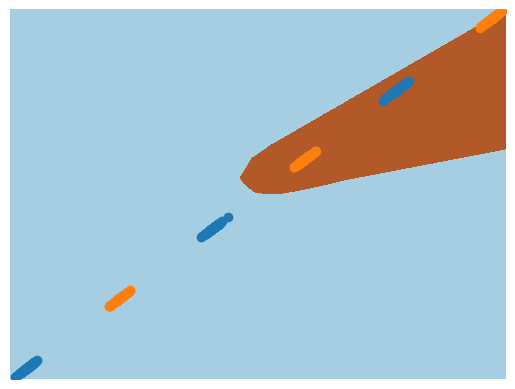

Epoch 20 / 100: avg_train_loss = 7.806631460785866, test_Acc = 0.6666666865348816
Epoch 21 / 100: avg_train_loss = 7.644713640213013, test_Acc = 0.6666666865348816
Epoch 22 / 100: avg_train_loss = 7.6332994401454926, test_Acc = 0.6666666865348816
Epoch 23 / 100: avg_train_loss = 7.5969207137823105, test_Acc = 0.6666666865348816
Epoch 24 / 100: avg_train_loss = 7.70010045170784, test_Acc = 0.6666666865348816
Epoch 25 / 100: avg_train_loss = 7.156081467866898, test_Acc = 0.6666666865348816
Epoch 26 / 100: avg_train_loss = 7.363974764943123, test_Acc = 0.6666666865348816
Epoch 27 / 100: avg_train_loss = 6.889774367213249, test_Acc = 0.8333333134651184
Epoch 28 / 100: avg_train_loss = 5.738988049328327, test_Acc = 1.0
Epoch 29 / 100: avg_train_loss = 4.852630749344826, test_Acc = 0.9816666841506958


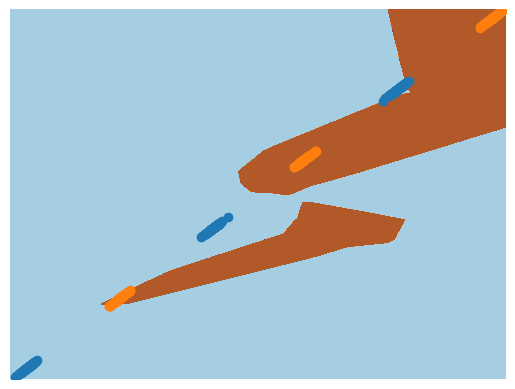

Epoch 30 / 100: avg_train_loss = 4.433107286691666, test_Acc = 1.0
Epoch 31 / 100: avg_train_loss = 3.4625865258276463, test_Acc = 1.0
Epoch 32 / 100: avg_train_loss = 2.9355443455278873, test_Acc = 1.0
Epoch 33 / 100: avg_train_loss = 2.4608955085277557, test_Acc = 1.0
Epoch 34 / 100: avg_train_loss = 2.102639351040125, test_Acc = 1.0
Epoch 35 / 100: avg_train_loss = 1.6255314853042364, test_Acc = 0.9933333396911621
Epoch 36 / 100: avg_train_loss = 1.4678788091987371, test_Acc = 1.0
Epoch 37 / 100: avg_train_loss = 1.2684913072735071, test_Acc = 1.0
Epoch 38 / 100: avg_train_loss = 1.0077187977731228, test_Acc = 1.0
Epoch 39 / 100: avg_train_loss = 0.9211489586159587, test_Acc = 1.0


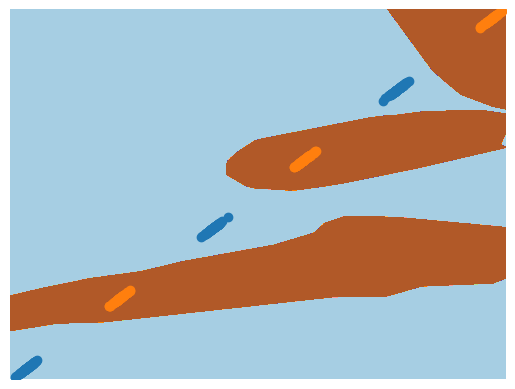

Epoch 40 / 100: avg_train_loss = 0.7772544482722878, test_Acc = 1.0
Epoch 41 / 100: avg_train_loss = 0.6757144015282393, test_Acc = 1.0
Epoch 42 / 100: avg_train_loss = 0.592353256419301, test_Acc = 1.0
Epoch 43 / 100: avg_train_loss = 0.5368504226207733, test_Acc = 1.0
Epoch 44 / 100: avg_train_loss = 0.5053198281675577, test_Acc = 1.0
Epoch 45 / 100: avg_train_loss = 0.4321644213050604, test_Acc = 1.0
Epoch 46 / 100: avg_train_loss = 0.39047169825062156, test_Acc = 1.0
Epoch 47 / 100: avg_train_loss = 0.3600332220084965, test_Acc = 1.0
Epoch 48 / 100: avg_train_loss = 0.3342058314010501, test_Acc = 1.0
Epoch 49 / 100: avg_train_loss = 0.30588548630476, test_Acc = 1.0


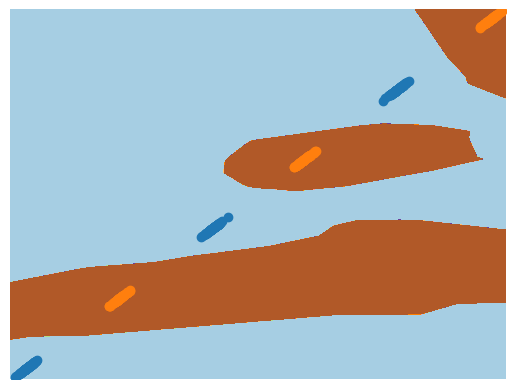

Epoch 50 / 100: avg_train_loss = 0.28602654999122024, test_Acc = 1.0
Epoch 51 / 100: avg_train_loss = 0.2596039976924658, test_Acc = 1.0
Epoch 52 / 100: avg_train_loss = 0.2347497222945094, test_Acc = 1.0
Epoch 53 / 100: avg_train_loss = 0.21972179086878896, test_Acc = 1.0
Epoch 54 / 100: avg_train_loss = 0.1995940173510462, test_Acc = 1.0
Epoch 55 / 100: avg_train_loss = 0.19174103438854218, test_Acc = 1.0
Epoch 56 / 100: avg_train_loss = 0.17375004524365067, test_Acc = 1.0
Epoch 57 / 100: avg_train_loss = 0.16226939880289137, test_Acc = 1.0
Epoch 58 / 100: avg_train_loss = 0.15135160530917346, test_Acc = 1.0
Epoch 59 / 100: avg_train_loss = 0.1429696010891348, test_Acc = 1.0


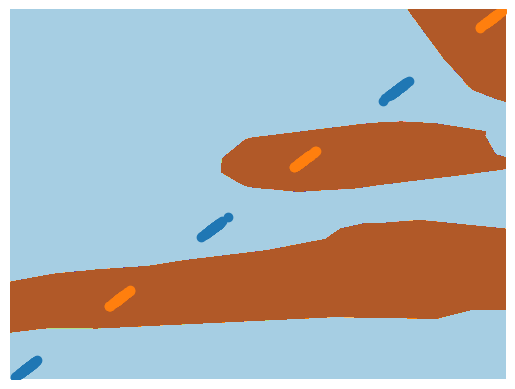

Epoch 60 / 100: avg_train_loss = 0.1335221892222762, test_Acc = 1.0
Epoch 61 / 100: avg_train_loss = 0.13259812258183956, test_Acc = 1.0
Epoch 62 / 100: avg_train_loss = 0.12051802431233227, test_Acc = 1.0
Epoch 63 / 100: avg_train_loss = 0.1117350566200912, test_Acc = 1.0
Epoch 64 / 100: avg_train_loss = 0.10675104381516576, test_Acc = 1.0
Epoch 65 / 100: avg_train_loss = 0.10112266382202506, test_Acc = 1.0
Epoch 66 / 100: avg_train_loss = 0.09602829581126571, test_Acc = 1.0
Epoch 67 / 100: avg_train_loss = 0.09090625529643148, test_Acc = 1.0
Epoch 68 / 100: avg_train_loss = 0.08602950791828334, test_Acc = 1.0
Epoch 69 / 100: avg_train_loss = 0.0817324691452086, test_Acc = 1.0


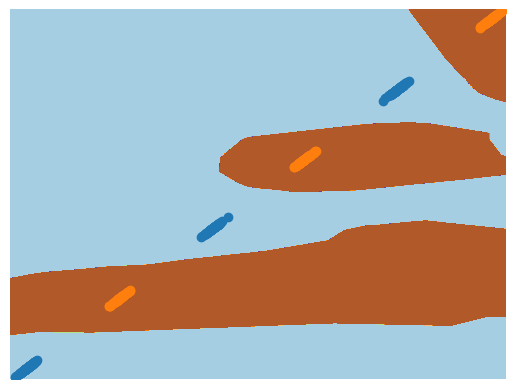

Epoch 70 / 100: avg_train_loss = 0.07722824835218489, test_Acc = 1.0
Epoch 71 / 100: avg_train_loss = 0.07515905343461782, test_Acc = 1.0
Epoch 72 / 100: avg_train_loss = 0.07052435597870499, test_Acc = 1.0
Epoch 73 / 100: avg_train_loss = 0.06661018705926836, test_Acc = 1.0
Epoch 74 / 100: avg_train_loss = 0.06477494991850108, test_Acc = 1.0
Epoch 75 / 100: avg_train_loss = 0.06038898590486497, test_Acc = 1.0
Epoch 76 / 100: avg_train_loss = 0.05827107455115765, test_Acc = 1.0
Epoch 77 / 100: avg_train_loss = 0.05735673778690398, test_Acc = 1.0
Epoch 78 / 100: avg_train_loss = 0.053780979418661445, test_Acc = 1.0
Epoch 79 / 100: avg_train_loss = 0.05051330919377506, test_Acc = 1.0


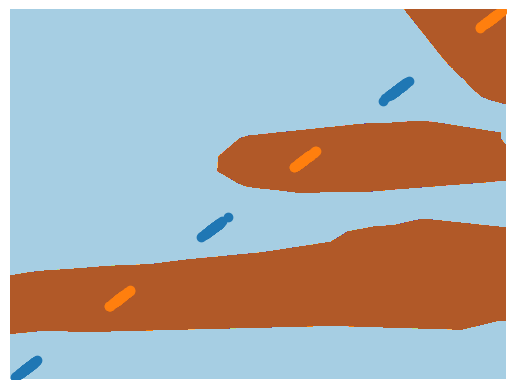

Epoch 80 / 100: avg_train_loss = 0.0491757407435216, test_Acc = 1.0
Epoch 81 / 100: avg_train_loss = 0.04736796021461487, test_Acc = 1.0
Epoch 82 / 100: avg_train_loss = 0.0444601618219167, test_Acc = 1.0
Epoch 83 / 100: avg_train_loss = 0.04285454039927572, test_Acc = 1.0
Epoch 84 / 100: avg_train_loss = 0.041265690815635026, test_Acc = 1.0
Epoch 85 / 100: avg_train_loss = 0.039253433933481574, test_Acc = 1.0
Epoch 86 / 100: avg_train_loss = 0.03769333194941282, test_Acc = 1.0
Epoch 87 / 100: avg_train_loss = 0.03673843527212739, test_Acc = 1.0
Epoch 88 / 100: avg_train_loss = 0.034954499860759825, test_Acc = 1.0
Epoch 89 / 100: avg_train_loss = 0.03325850050896406, test_Acc = 1.0


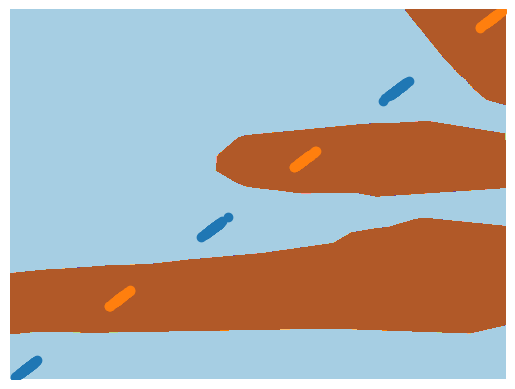

Epoch 90 / 100: avg_train_loss = 0.03211624315008521, test_Acc = 1.0
Epoch 91 / 100: avg_train_loss = 0.030913235852494836, test_Acc = 1.0
Epoch 92 / 100: avg_train_loss = 0.02975680271629244, test_Acc = 1.0
Epoch 93 / 100: avg_train_loss = 0.02888654120033607, test_Acc = 1.0
Epoch 94 / 100: avg_train_loss = 0.028770480712410063, test_Acc = 1.0
Epoch 95 / 100: avg_train_loss = 0.02665671074646525, test_Acc = 1.0
Epoch 96 / 100: avg_train_loss = 0.025776860886253417, test_Acc = 1.0
Epoch 97 / 100: avg_train_loss = 0.024566992709878832, test_Acc = 1.0
Epoch 98 / 100: avg_train_loss = 0.02389976810081862, test_Acc = 1.0
Epoch 99 / 100: avg_train_loss = 0.023019385553197935, test_Acc = 1.0


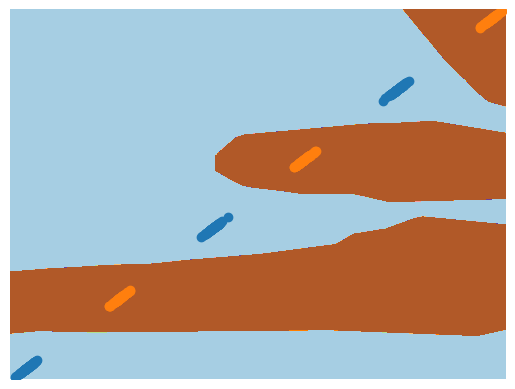

In [55]:

with torch.no_grad():
  # define bounds of the domain
  min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
  min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
  # define the x and y scale
  x1grid = torch.arange(min1, max1, 0.1)
  x2grid = torch.arange(min2, max2, 0.1)
  # create all of the lines and rows of the grid
  xx, yy = torch.meshgrid(x1grid, x2grid)
  # flatten each grid to a vector
  r1, r2 = xx.flatten(), yy.flatten()
  r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
  # horizontal stack vectors to create x1,x2 input for the model
  grid = torch.cat((r1,r2), dim=1).cpu()
  # make predictions for the grid
  yhat = net.predict(grid)
  # reshape the predictions back into a grid
  zz = yhat.reshape(xx.shape).detach().cpu()
  # plot the grid of x, y and z values as a surface
  plt.figure()
  xx, yy = xx.numpy(), yy.numpy()
  plt.contourf(xx, yy, zz, cmap='Paired')
  plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
  plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')
  plt.axis('off')
  plt.show()


n_epochs = 100
for epoch in range(n_epochs):
  avg_loss = 0
  for i, (data, labels) in enumerate(dataloader):
    data, labels = data.cpu(), labels.cpu()
    optimizer.zero_grad()
    out = net(data)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
  # end of epoch
  #eval
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (data, labels) in enumerate(testloader):
      data, labels = data.cpu(), labels.cpu()
      correct += (torch.sum(net.predict(data)==labels))
      total += data.shape[0]

    print(f'Epoch {epoch} / {n_epochs}: avg_train_loss = {avg_loss / i}, test_Acc = {correct / total}')
    if epoch==0 or epoch % 10 == 9:
      # define bounds of the domain
      min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
      min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
      # define the x and y scale
      x1grid = torch.arange(min1, max1, 0.1)
      x2grid = torch.arange(min2, max2, 0.1)
      # create all of the lines and rows of the grid
      xx, yy = torch.meshgrid(x1grid, x2grid)
      # flatten each grid to a vector
      r1, r2 = xx.flatten(), yy.flatten()
      r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
      # horizontal stack vectors to create x1,x2 input for the model
      grid = torch.cat((r1,r2), dim=1).cpu()
      # make predictions for the grid
      yhat = net.predict(grid)
      # reshape the predictions back into a grid
      zz = yhat.reshape(xx.shape).detach().cpu()
      # plot the grid of x, y and z values as a surface
      plt.figure()
      xx, yy = xx.numpy(), yy.numpy()
      plt.contourf(xx, yy, zz, cmap='Paired')
      plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
      plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')
      plt.axis('off')
      plt.show()

eval adversarial rob

In [56]:
corr, tot = 0, 0
for i, (data, labels) in enumerate(testloader):
  data, labels = data.cpu(), labels.cpu()
  x_adv = targeted_pgd_linf(net, data, (labels+1)%2, 10, eps=15, step_size=2)
  with torch.no_grad():
    pred = net(x_adv).argmax(-1)
    tot += labels.shape[0]
    corr += pred.eq(labels).sum()
print(f'correct in {corr} from {tot}')

correct in 600 from 600


NN

In [57]:
def nearest(values, queries):
  indices = []
  for q in queries:
    distances = torch.sqrt(torch.pow(q.unsqueeze(0) - values, 2).sum(dim=1))
    distances[distances == 0] = torch.inf
    indices.append(distances.argmin())
  return values[indices]


X, Y = dataset[0:6000]
data = [X.unsqueeze(0)]
for cls in range(2):
  nearest_neighbor = []
  nearest_neighbor.append(nearest(values=X[3000*cls:3000*(cls+1)],queries=X[0:3000]))
  nearest_neighbor.append(nearest(values=X[3000*cls:3000*(cls+1)],queries=X[3000:]))
  nearest_neighbor = torch.cat(nearest_neighbor)
  data.append((nearest_neighbor - X).unsqueeze(0))
data = torch.cat(data).permute(1,0,2)

Second approach with NN ground-truth gradients.

In [59]:
dataset = torch.utils.data.TensorDataset(data, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)

In [60]:
torch.manual_seed(2)

class MLP(nn.Module):
    def __init__(self):
      super(MLP, self).__init__()
      self.layers = nn.Sequential(
          nn.Linear(in_features=2, out_features=32),
          nn.ReLU(),
          nn.Linear(in_features=32, out_features=2)
      )
    def forward(self, x):
      return self.layers(x)

    def predict(self, x):
      out = self.layers(x)
      return torch.argmax(out, dim=1)

net_ours = MLP().cpu()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_ours.parameters(), lr=0.01)

C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2792002154.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2792002154.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')


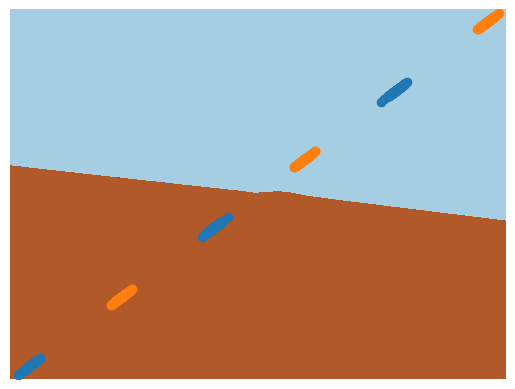

Epoch 0 / 100: avg_train_loss = 132.2436227798462, test_Acc = 0.6666666865348816


C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2792002154.py:83: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
C:\Users\Yohann\AppData\Local\Temp\ipykernel_2556\2792002154.py:84: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')


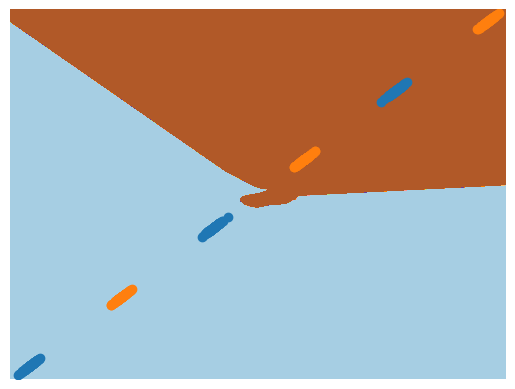

Epoch 1 / 100: avg_train_loss = 126.80892181396484, test_Acc = 0.3333333432674408
Epoch 2 / 100: avg_train_loss = 109.0701801776886, test_Acc = 0.3333333432674408
Epoch 3 / 100: avg_train_loss = 107.71726441383362, test_Acc = 0.5
Epoch 4 / 100: avg_train_loss = 109.32760465145111, test_Acc = 0.3333333432674408
Epoch 5 / 100: avg_train_loss = 111.58068418502808, test_Acc = 0.5433333516120911
Epoch 6 / 100: avg_train_loss = 122.20603013038635, test_Acc = 0.33666667342185974
Epoch 7 / 100: avg_train_loss = 113.76206469535828, test_Acc = 0.3333333432674408
Epoch 8 / 100: avg_train_loss = 112.517160654068, test_Acc = 0.5
Epoch 9 / 100: avg_train_loss = 109.1205883026123, test_Acc = 0.3333333432674408


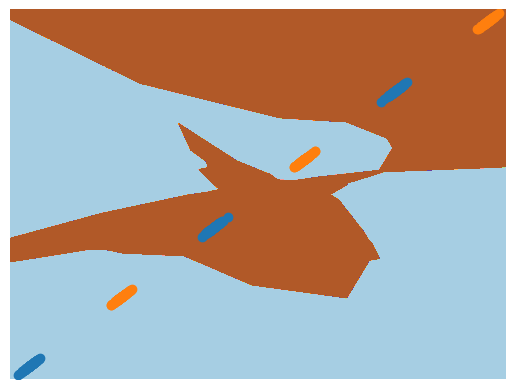

Epoch 10 / 100: avg_train_loss = 104.3086725473404, test_Acc = 0.5
Epoch 11 / 100: avg_train_loss = 106.40419840812683, test_Acc = 0.5
Epoch 12 / 100: avg_train_loss = 100.49474012851715, test_Acc = 0.70333331823349
Epoch 13 / 100: avg_train_loss = 101.19157302379608, test_Acc = 0.8333333134651184
Epoch 14 / 100: avg_train_loss = 100.7617164850235, test_Acc = 0.8316666483879089
Epoch 15 / 100: avg_train_loss = 103.6593108177185, test_Acc = 0.8333333134651184
Epoch 16 / 100: avg_train_loss = 98.90897142887115, test_Acc = 0.6666666865348816
Epoch 17 / 100: avg_train_loss = 97.92714333534241, test_Acc = 0.6666666865348816
Epoch 18 / 100: avg_train_loss = 97.66005671024323, test_Acc = 0.5366666913032532
Epoch 19 / 100: avg_train_loss = 99.55112397670746, test_Acc = 0.7766666412353516


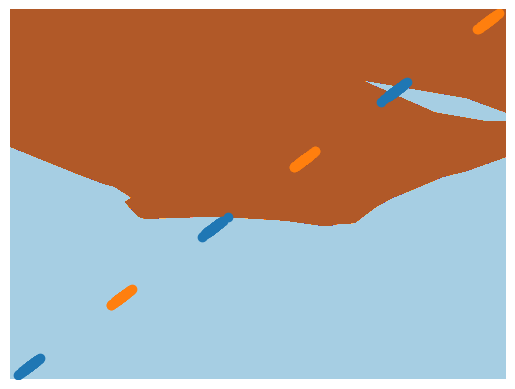

Epoch 20 / 100: avg_train_loss = 104.64440310001373, test_Acc = 0.6700000166893005
Epoch 21 / 100: avg_train_loss = 98.11130714416504, test_Acc = 0.6666666865348816
Epoch 22 / 100: avg_train_loss = 99.70925903320312, test_Acc = 0.7133333086967468
Epoch 23 / 100: avg_train_loss = 99.3481422662735, test_Acc = 0.6633333563804626
Epoch 24 / 100: avg_train_loss = 103.70634281635284, test_Acc = 0.6666666865348816
Epoch 25 / 100: avg_train_loss = 100.31733429431915, test_Acc = 0.6666666865348816
Epoch 26 / 100: avg_train_loss = 96.62980723381042, test_Acc = 0.6666666865348816
Epoch 27 / 100: avg_train_loss = 99.46355938911438, test_Acc = 0.6666666865348816
Epoch 28 / 100: avg_train_loss = 96.32578754425049, test_Acc = 0.6666666865348816
Epoch 29 / 100: avg_train_loss = 101.14008271694183, test_Acc = 0.7266666889190674


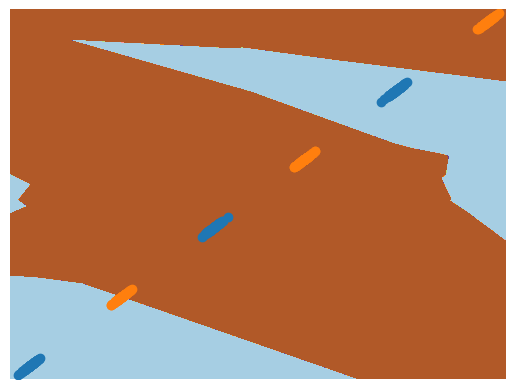

Epoch 30 / 100: avg_train_loss = 99.85949659347534, test_Acc = 0.6666666865348816
Epoch 31 / 100: avg_train_loss = 100.73697531223297, test_Acc = 0.5049999952316284
Epoch 32 / 100: avg_train_loss = 102.15962326526642, test_Acc = 0.6600000262260437
Epoch 33 / 100: avg_train_loss = 99.28949308395386, test_Acc = 0.6666666865348816
Epoch 34 / 100: avg_train_loss = 100.22821068763733, test_Acc = 0.5
Epoch 35 / 100: avg_train_loss = 101.77444911003113, test_Acc = 0.8100000023841858
Epoch 36 / 100: avg_train_loss = 100.93924617767334, test_Acc = 0.6666666865348816
Epoch 37 / 100: avg_train_loss = 98.43506598472595, test_Acc = 0.6549999713897705
Epoch 38 / 100: avg_train_loss = 100.28801822662354, test_Acc = 0.7699999809265137
Epoch 39 / 100: avg_train_loss = 100.77103459835052, test_Acc = 0.6666666865348816


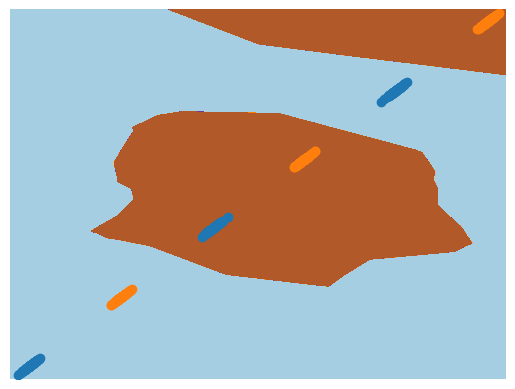

Epoch 40 / 100: avg_train_loss = 101.01624619960785, test_Acc = 0.6666666865348816
Epoch 41 / 100: avg_train_loss = 99.68530285358429, test_Acc = 0.8266666531562805
Epoch 42 / 100: avg_train_loss = 99.44323778152466, test_Acc = 0.6666666865348816
Epoch 43 / 100: avg_train_loss = 100.34313488006592, test_Acc = 0.6666666865348816
Epoch 44 / 100: avg_train_loss = 100.262335896492, test_Acc = 0.6666666865348816
Epoch 45 / 100: avg_train_loss = 99.59902894496918, test_Acc = 0.8333333134651184
Epoch 46 / 100: avg_train_loss = 96.69635450839996, test_Acc = 0.8433333039283752
Epoch 47 / 100: avg_train_loss = 94.76469314098358, test_Acc = 0.8333333134651184
Epoch 48 / 100: avg_train_loss = 94.58773899078369, test_Acc = 1.0
Epoch 49 / 100: avg_train_loss = 94.10638749599457, test_Acc = 0.9666666388511658


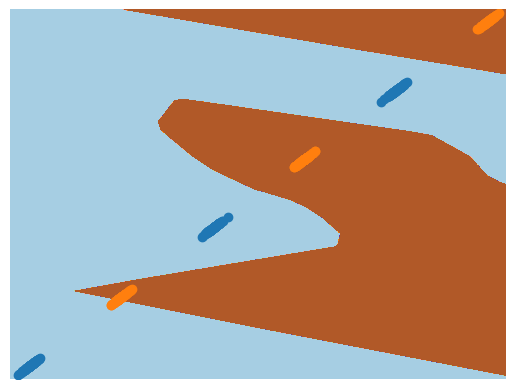

Epoch 50 / 100: avg_train_loss = 89.24951636791229, test_Acc = 1.0
Epoch 51 / 100: avg_train_loss = 91.88635909557343, test_Acc = 1.0
Epoch 52 / 100: avg_train_loss = 91.01300048828125, test_Acc = 1.0
Epoch 53 / 100: avg_train_loss = 91.75913071632385, test_Acc = 1.0
Epoch 54 / 100: avg_train_loss = 90.6690833568573, test_Acc = 1.0
Epoch 55 / 100: avg_train_loss = 89.22972011566162, test_Acc = 1.0
Epoch 56 / 100: avg_train_loss = 89.6976751089096, test_Acc = 1.0
Epoch 57 / 100: avg_train_loss = 90.12335276603699, test_Acc = 1.0
Epoch 58 / 100: avg_train_loss = 89.23352706432343, test_Acc = 1.0
Epoch 59 / 100: avg_train_loss = 89.82596635818481, test_Acc = 1.0


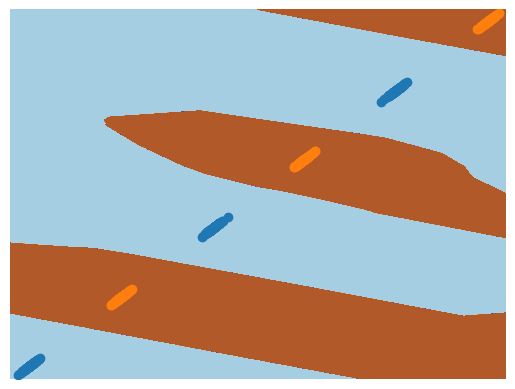

Epoch 60 / 100: avg_train_loss = 89.54548394680023, test_Acc = 1.0
Epoch 61 / 100: avg_train_loss = 88.57882130146027, test_Acc = 1.0
Epoch 62 / 100: avg_train_loss = 87.22225522994995, test_Acc = 1.0
Epoch 63 / 100: avg_train_loss = 87.5665454864502, test_Acc = 1.0
Epoch 64 / 100: avg_train_loss = 87.42253804206848, test_Acc = 1.0
Epoch 65 / 100: avg_train_loss = 89.4045375585556, test_Acc = 1.0
Epoch 66 / 100: avg_train_loss = 88.89440762996674, test_Acc = 1.0
Epoch 67 / 100: avg_train_loss = 87.32150375843048, test_Acc = 1.0
Epoch 68 / 100: avg_train_loss = 87.59367525577545, test_Acc = 1.0
Epoch 69 / 100: avg_train_loss = 84.88077187538147, test_Acc = 1.0


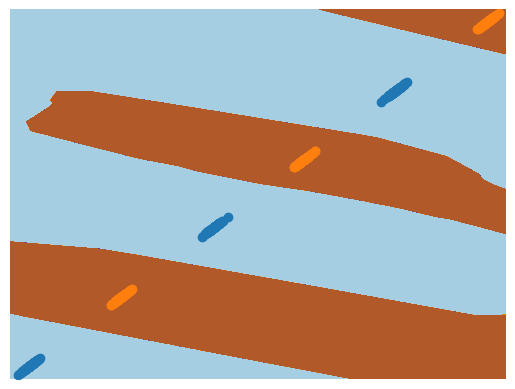

Epoch 70 / 100: avg_train_loss = 88.09611546993256, test_Acc = 0.9933333396911621
Epoch 71 / 100: avg_train_loss = 89.1916663646698, test_Acc = 1.0
Epoch 72 / 100: avg_train_loss = 86.53409719467163, test_Acc = 1.0
Epoch 73 / 100: avg_train_loss = 84.16854441165924, test_Acc = 1.0
Epoch 74 / 100: avg_train_loss = 84.42299103736877, test_Acc = 1.0
Epoch 75 / 100: avg_train_loss = 89.03800511360168, test_Acc = 1.0
Epoch 76 / 100: avg_train_loss = 83.7966741323471, test_Acc = 1.0
Epoch 77 / 100: avg_train_loss = 83.13999044895172, test_Acc = 1.0
Epoch 78 / 100: avg_train_loss = 83.89879965782166, test_Acc = 1.0
Epoch 79 / 100: avg_train_loss = 82.86349773406982, test_Acc = 1.0


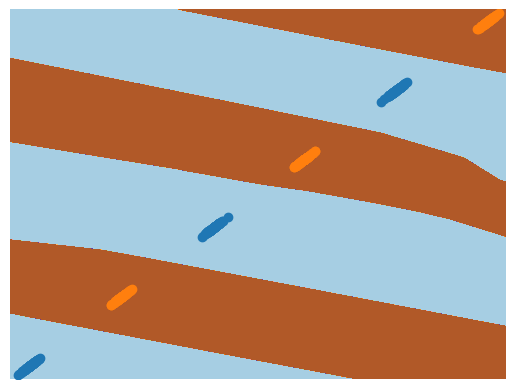

Epoch 80 / 100: avg_train_loss = 84.47375655174255, test_Acc = 1.0
Epoch 81 / 100: avg_train_loss = 86.89911115169525, test_Acc = 1.0
Epoch 82 / 100: avg_train_loss = 84.24985778331757, test_Acc = 1.0
Epoch 83 / 100: avg_train_loss = 84.8124258518219, test_Acc = 1.0
Epoch 84 / 100: avg_train_loss = 84.67704951763153, test_Acc = 1.0
Epoch 85 / 100: avg_train_loss = 88.21811139583588, test_Acc = 1.0
Epoch 86 / 100: avg_train_loss = 86.32713544368744, test_Acc = 1.0
Epoch 87 / 100: avg_train_loss = 86.32644355297089, test_Acc = 1.0
Epoch 88 / 100: avg_train_loss = 87.98242950439453, test_Acc = 1.0
Epoch 89 / 100: avg_train_loss = 87.56369256973267, test_Acc = 1.0


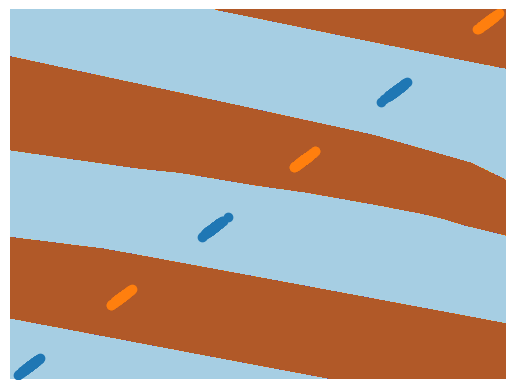

Epoch 90 / 100: avg_train_loss = 85.44534349441528, test_Acc = 1.0
Epoch 91 / 100: avg_train_loss = 84.09019565582275, test_Acc = 1.0
Epoch 92 / 100: avg_train_loss = 86.24973285198212, test_Acc = 1.0
Epoch 93 / 100: avg_train_loss = 89.1030741930008, test_Acc = 1.0
Epoch 94 / 100: avg_train_loss = 85.64228570461273, test_Acc = 1.0
Epoch 95 / 100: avg_train_loss = 83.98447144031525, test_Acc = 1.0
Epoch 96 / 100: avg_train_loss = 87.57570767402649, test_Acc = 1.0
Epoch 97 / 100: avg_train_loss = 88.72825074195862, test_Acc = 1.0
Epoch 98 / 100: avg_train_loss = 87.27882754802704, test_Acc = 1.0
Epoch 99 / 100: avg_train_loss = 84.3663501739502, test_Acc = 1.0


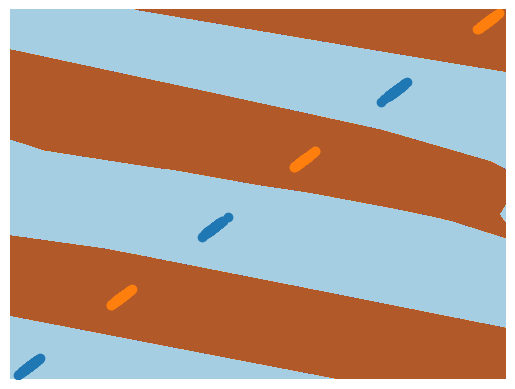

In [61]:
%matplotlib inline

with torch.no_grad():
  # define bounds of the domain
  min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
  min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
  # define the x and y scale
  x1grid = torch.arange(min1, max1, 0.1)
  x2grid = torch.arange(min2, max2, 0.1)
  # create all of the lines and rows of the grid
  xx, yy = torch.meshgrid(x1grid, x2grid)
  # flatten each grid to a vector
  r1, r2 = xx.flatten(), yy.flatten()
  r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
  # horizontal stack vectors to create x1,x2 input for the model
  grid = torch.cat((r1,r2), dim=1).cpu()
  # make predictions for the grid
  yhat = net_ours.predict(grid)
  # reshape the predictions back into a grid
  zz = yhat.reshape(xx.shape).detach().cpu()
  # plot the grid of x, y and z values as a surface
  plt.figure()
  xx, yy = xx.numpy(), yy.numpy()
  plt.contourf(xx, yy, zz, cmap='Paired')
  plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
  plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')
  plt.axis('off')
  plt.show()


n_epochs = 100
for epoch in range(n_epochs):
  avg_loss = 0
  for i, (data, labels) in enumerate(dataloader):
    data, labels = data.cpu(), labels.cpu()
    images, pag = data[:,0].requires_grad_(True), data[:,1:]
    optimizer.zero_grad()
    out = net_ours(images)
    loss = criterion(out, labels)
    pag_loss = 0
    for cls in range(2):
      dummy_loss = torch.nn.CrossEntropyLoss()(net_ours(images), torch.ones_like(labels, dtype=torch.long).cpu()*cls)
      grad, = torch.autograd.grad(-1 * dummy_loss, [images], create_graph=True)
      pag_loss += (1. - torch.nn.CosineSimilarity(dim=1)(grad, pag[:, cls]).mean())
    loss += 5 * pag_loss   # determine pag coeff
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
  # end of epoch
  #eval
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (data, labels) in enumerate(testloader):
      data, labels = data.cpu(), labels.cpu()
      correct += (torch.sum(net_ours.predict(data)==labels))
      total += data.shape[0]

    print(f'Epoch {epoch} / {n_epochs}: avg_train_loss = {avg_loss / i}, test_Acc = {correct / total}')
    if epoch==0 or epoch % 10 == 9:
      # define bounds of the domain
      min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
      min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
      # define the x and y scale
      x1grid = torch.arange(min1, max1, 0.1)
      x2grid = torch.arange(min2, max2, 0.1)
      # create all of the lines and rows of the grid
      xx, yy = torch.meshgrid(x1grid, x2grid)
      # flatten each grid to a vector
      r1, r2 = xx.flatten(), yy.flatten()
      r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
      # horizontal stack vectors to create x1,x2 input for the model
      grid = torch.cat((r1,r2), dim=1).cpu()
      # make predictions for the grid
      yhat = net_ours.predict(grid)
      # reshape the predictions back into a grid
      
      zz = yhat.reshape(xx.shape).detach().cpu()
      # plot the grid of x, y and z values as a surface
      plt.figure()
      xx, yy = xx.numpy(), yy.numpy()
      plt.contourf(xx, yy, zz, cmap='Paired')
      plt.scatter(mode1[:,0], mode1[:,1], cmap='Paired')
      plt.scatter(mode2[:,0], mode2[:,1], cmap='Paired')
      plt.axis('off')
      plt.show()

adversarial attack

In [62]:
corr, tot = 0, 0
for i, (data, labels) in enumerate(testloader):
  data, labels = data.cpu(), labels.cpu()
  x_adv = targeted_pgd_linf(net_ours, data, (labels+1)%2, 10, eps=15, step_size=2)
  with torch.no_grad():
    pred = net_ours(x_adv).argmax(-1)
    tot += labels.shape[0]
    corr += pred.eq(labels).sum()
print(f'correct in {corr} from {tot}')

correct in 600 from 600


Linf seems not to work well here in this 2D setup, L2 gives a real test.

Code adapted from Ganz et al. 
Thanks again to Mr Ganz for his time.